# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

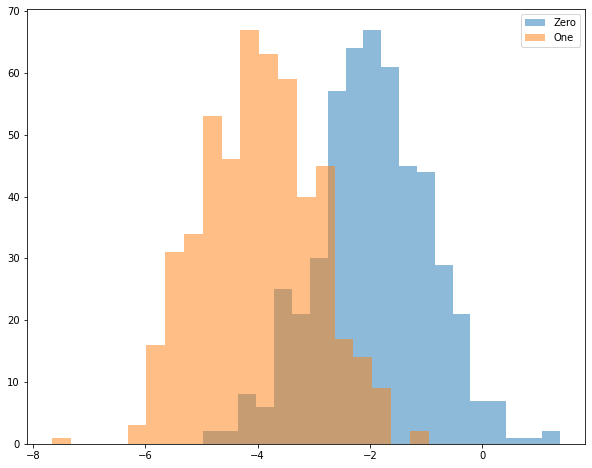

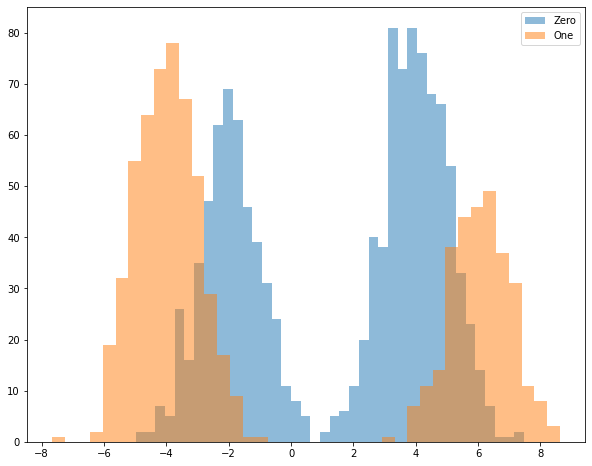

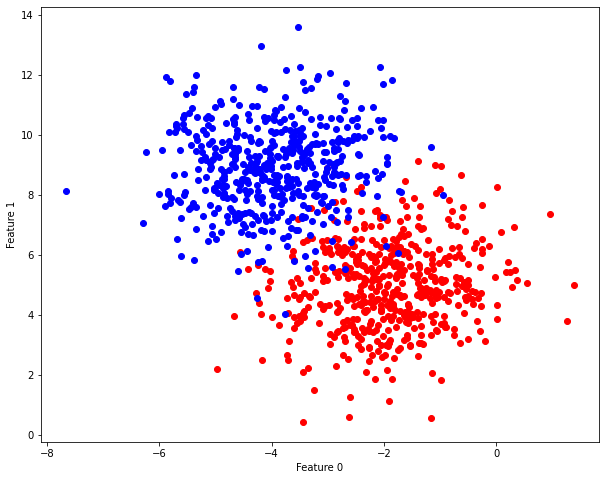

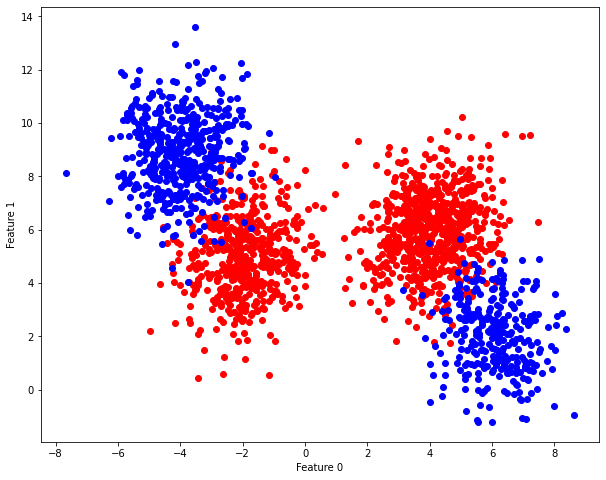

In [4]:
#### Your code here ####
train_set = training_set.values
# First 1000
first = train_set[0:1000,:]
first_class_zero = first[first[:,-1] == 0]
first_class_one = first[first[:,-1] == 1]

# Full data
class_zero = train_set[train_set[:,-1] == 0]
class_one = train_set[train_set[:,-1] == 1]

# First Feature only
# 1:
plt.hist(first_class_zero[:,0], bins=20, alpha=0.5, label='Zero')
plt.hist(first_class_one[:,0], bins=20, alpha=0.5, label='One')
plt.legend(loc='upper right')
plt.show()

# 2:
plt.hist(class_zero[:,0], bins=40, alpha=0.5, label='Zero')
plt.hist(class_one[:,0], bins=40, alpha=0.5, label='One')
plt.legend(loc='upper right')
plt.show()

# For both features
# 1:
plt.scatter(first[:,0][first[:,-1] == 0], first[:,1][first[:,-1] == 0] , c='r')
plt.scatter(first[:,0][first[:,-1] == 1], first[:,1][first[:,-1] == 1] , c='b')
plt.ylabel('Feature 1')
plt.xlabel('Feature 0')
plt.show()

# 2:
plt.scatter(train_set[:,0][train_set[:,-1] == 0], train_set[:,1][train_set[:,-1] == 0] , c='r')
plt.scatter(train_set[:,0][train_set[:,-1] == 1], train_set[:,1][train_set[:,-1] == 1] , c='b')
plt.ylabel('Feature 1')
plt.xlabel('Feature 0')
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        X = np.insert(X,0,1,axis=1)
        n_examples, n_features = X.shape
        costs_list = []
        np.random.seed(self.random_state)
        theta = np.full(n_features, np.random.rand())
        
        for _ in range(self.n_iter):
            
            h = self.sigmoid(np.matmul(X,theta))
            J = -(1/n_examples) * np.sum(y*np.log(h) + ((1-y)*np.log(1-h)))
            
            if _ > 0 and (costs_list[-1] - J) < self.eps:
                break 
            
            costs_list.append(J)
            theta = theta - self.eta * np.matmul((h-y) , X)
            
        self.theta = theta
        self.costs_list = costs_list
        self.num_iter = _
        self.cost = costs_list[-1]
            
    def predict(self, X):
        """Return the predicted class label"""
        X = np.insert(X,0,1,axis=1)
        predictions = self.sigmoid(np.dot(X,self.theta))
        p = [1 if i >= 0.5 else 0 for i in predictions]
        return np.array(p)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [6]:
def split(data, numFolds):
    if (len(data) % numFolds == 0):
        return np.split(data,numFolds)
    else:
        # np.split() like implementation that works with any given numFolds:
        copy = np.copy(data)
        dataSplit = []
        dataCopy = list(copy)
        foldSize = int(len(data) / numFolds)
        for _ in range(numFolds):
            fold = []
            while (len(fold) < foldSize):
                fold.append(dataCopy.pop(0))
            dataSplit.append(np.array(fold))
        return dataSplit

def compute_accuracy(labels, predictions):
    success = 0
    for i in range(len(labels)):
        if labels[i] == predictions[i]:
            success += 1
    accuracy = (success / float(len(labels)) * 100.0)
    return accuracy

def validate(data, numFolds, eta, eps):
    lr = LogisticRegressionGD(eta=eta, eps=eps)
    folds = split(data, numFolds)
    scores = []
    
    for i,fold in enumerate(folds):
        train = folds.copy()
        train = train.pop(i)
        test = fold.copy()
        
        trainLabels = train[:,-1]
        trainSet = train[:,:-1]
        
        lr.fit(np.array(trainSet),np.array(trainLabels))
        
        testLabels = test[:,-1]
        testSet = test[:,:-1]
        
        predictions = lr.predict(testSet)
        accuracy = compute_accuracy(testLabels, predictions)
        scores.append(accuracy)
    scores_np = np.array(scores)
    return np.mean(scores)

def best_params(data, numFolds, etas, epss):
    copy = np.copy(data)
    np.random.seed(1)
    np.random.shuffle(copy)
    k = numFolds
    best_accuracy = 0
    best_eta = 0
    best_eps = 0
    for eta in etas:
        for eps in epss:
            accuracy = validate(copy, k, eta, eps)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_eta = eta
                best_eps = eps
    print(f'The best eta is: {best_eta} and the best eps is {best_eps}, with the mean accuracy of {best_accuracy}%')
    return best_eta, best_eps

In [7]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
best_eta, best_eps = best_params(train_set, 5, etas, epss)

The best eta is: 5e-05 and the best eps is 1e-06, with the mean accuracy of 74.8%


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    power = -0.5 * np.power((data-mu)/sigma , 2)
    return (1 / (sigma * np.sqrt(2*np.pi))) * np.exp(power)

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """ 
        self.w = np.full(self.k, 1/self.k)
        np.random.seed(self.random_state)
        self.mu = np.random.rand(self.k)
        self.sigma = np.random.rand(self.k)
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        responsibilities = self.w * norm_pdf(data, self.mu, self.sigma) 
        responsibilities /= np.sum(responsibilities, axis = 1, keepdims=True)
        self.responsibilities = responsibilities

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N = len(data)
        responsibilities = self.responsibilities
        
        # Update w:
        new_w = (1/N) * np.sum(responsibilities, axis=0)
        
        # Update Mu:
        new_mu = (1/(new_w * N)) * np.sum(responsibilities * data, axis=0)
        
        # Update Sigma:
        x_sub_mu_sq = np.power(data - new_mu , 2)
        new_sigma = np.sqrt( (1/(new_w * N)) * np.sum(responsibilities * x_sub_mu_sq, axis=0) )
        
        self.mu = new_mu
        self.sigma = new_sigma
        self.w = new_w
        
    def cost(self, data):
        responsibilities = self.w * norm_pdf(data, self.mu, self.sigma)
        return np.sum(-np.log(responsibilities))
    
    def difference(self, x, y):
        return float(np.amax(np.absolute(x - y)))
        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        self.init_params(data)
        w = self.w
        mu = self.mu
        sigma = self.sigma
        costs_list = []
        old_cost = self.cost(data)

        for _ in range(self.n_iter):
            # E
            self.expectation(data)
            # M
            self.maximization(data)
            new_cost = self.cost(data)
            # Check difference
            costs_list.append(new_cost)
            if self.difference(old_cost, new_cost) < self.eps:
                break
            old_cost = new_cost
            
        self.num_iter = _+1
        self.costs_list = costs_list

    def get_dist_params(self):
        return self.w, self.mu, self.sigma
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1):
        self.k = k
        self.random_state = random_state
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        classes, counts = np.unique(y, return_counts = True)
        self.prior = (counts / len(y))
        self.classes = classes
        self.num_classes = len(classes)
        self.num_features = X.shape[1]

        self.w = np.zeros([self.num_classes, self.num_features, self.k])
        self.mu = np.zeros([self.num_classes, self.num_features, self.k])
        self.sigma = np.zeros([self.num_classes, self.num_features, self.k])
        
        for i in range(self.num_classes):
            likelihood = 1
            classData = X[y == classes[i]]
            for j in range(self.num_features):
                prob = 0
                em = EM(k=self.k, random_state=self.random_state)
                em.fit(classData[:, j:j+1])
                self.w[i][j], self.mu[i][j], self.sigma[i][j] = em.get_dist_params()
        
    def predict(self, X):
        predictions = np.zeros([self.num_classes, X.shape[0]])
        for i in range(self.num_classes):
            likelihood = 1
            for j in range(self.num_features):
                prob = 0
                for k in range(self.k):
                    prob += self.w[i][j][k] * norm_pdf(X[:,j:j+1], self.mu[i][j][k], self.sigma[i][j][k])
                likelihood *= prob[:,0]
            predictions[i] = self.prior[i] * likelihood
        return np.argmax(predictions, axis=0)
    

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [11]:
#### Your code here ####
def lr_test(train_data, train_labels, test_data, test_labels, eta=best_eta, n_iter=10000, eps=best_eps, random_state=42):
    lr = LogisticRegressionGD(eta=eta, n_iter=n_iter, eps=eps, random_state=random_state)
    lr.fit(train_data, train_labels)
    train_pred = lr.predict(train_data)
    test_pred = lr.predict(test_data)
    train_acc = accuracy(train_labels, train_pred)
    test_acc = accuracy(test_labels, test_pred)
    return lr, train_acc, test_acc

def nb_test(train_data, train_labels, test_data, test_labels, k=1, eta=best_eta, n_iter=10000, eps=best_eps, random_state=42):
    nb = NaiveBayesGaussian(k=k, random_state=random_state)
    nb.fit(train_data, train_labels)
    train_pred = nb.predict(train_data)
    nb.fit(test_data, test_labels)
    test_pred = nb.predict(test_data)
    train_acc = accuracy(train_labels, train_pred)
    test_acc = accuracy(test_labels, test_pred)
    return nb, train_acc, test_acc

def accuracy(labels, predictions):
    success = 0
    for i in range(len(labels)):
        if predictions[i] == labels[i]:
            success += 1
    return (success / len(predictions)) * 100

# First 1000 Training Points
train_data = first[:, 0:-1]
train_labels = first[:, -1]

# First 500 Test Points
test_data = test_set.values[:500][:, 0:-1]
test_labels = test_set.values[:500][:, -1]

# Full Training Points
full_train_data = train_set[:,:-1]
full_train_labels = train_set[:,-1]

# Full Test Points
full_test_data = test_set.values[:, 0:-1]
full_test_labels = test_set.values[:, -1]


lr, lr_train_acc, lr_test_acc = lr_test(train_data, train_labels, test_data, test_labels)
nb, nb_train_acc, nb_test_acc = nb_test(train_data, train_labels, test_data, test_labels, k=1)

lr_full, lr_full_train_acc, lr_full_test_acc = lr_test(full_train_data, full_train_labels, full_test_data, full_test_labels)
nb_full, nb_full_train_acc, nb_full_test_acc = nb_test(full_train_data, full_train_labels, full_test_data, full_test_labels, k=2)

Logistic Regression: 1000 Points Train Accuracy: 96.5%
Logistic Regression: 500 Points Test Accuracy:   93.8%

Naive Bayes: 1000 Points Train Accuracy: 96.6%
Naive Bayes: 500 Points Test Accuracy:   94.19999999999999%



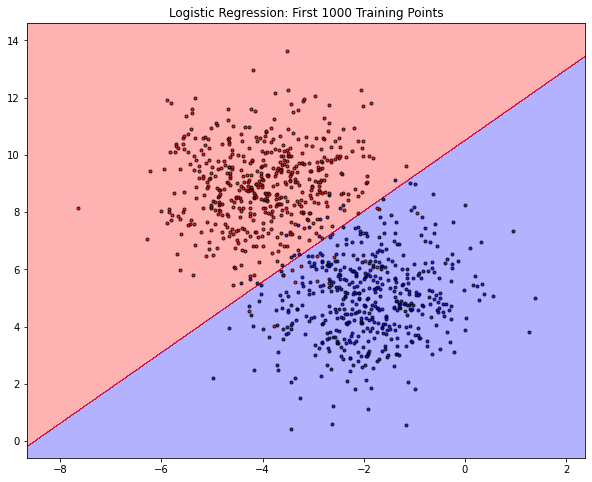

Explanation of the 1st graph: We can see that the data can be linear separated with minimal error.
We can see the line that was created by performing the Logistic Regression Algorithm.



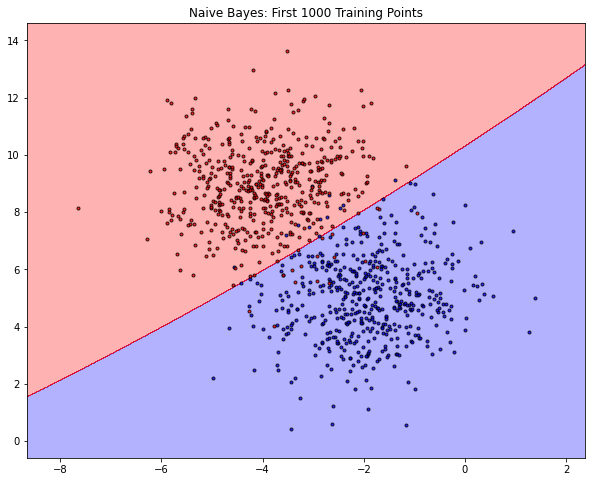

Explanation of the 2nd graph: This graph represents the Naïve Bayes Algorithm, which assumes the data is independent
Due to those assumptions, we can see that the line is non-linear and performs better separation than the Logistic Regression.



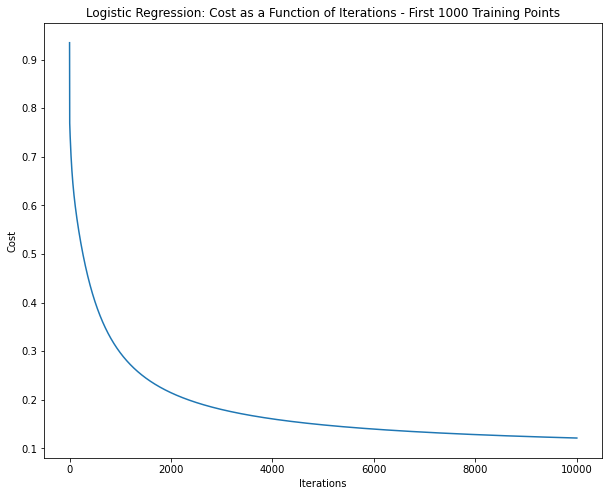

Explanation of the 3d graph: In this graph, which represents the cost of Logistic Regression vs Iterations, the cost starts high on the first iteration, and as we perform more iterations the cost reduces.
This is exactly what we wanted to see, because we aim to minimize the cost to get better performance, as seen on class.
Moreover, we van notice that the algorithm performed the maximum number of iterations and didn’t stop by the given epsilon.


Full Data set:
Logistic Regression: Full Points Train Accuracy: 80.9%
Logistic Regression: Full Points Test Accuracy:   80.4%

Naive Bayes: Full Points Train Accuracy: 92.15%
Naive Bayes: Full Points Test Accuracy:   90.5%



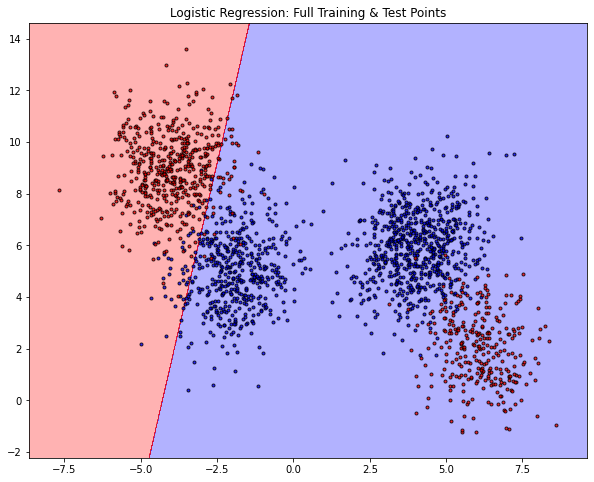

Explanation of the 4th graph: In this graph we see worse separation than the previous Logistic Regression separation graph, since we observe all the data points – which have 4 gaussians in different locations.
This is of course non-linear separated.
It aims to separate it as best as it can, with about 80% success rate – the gaussian in the down-right corner is not classified correctly.



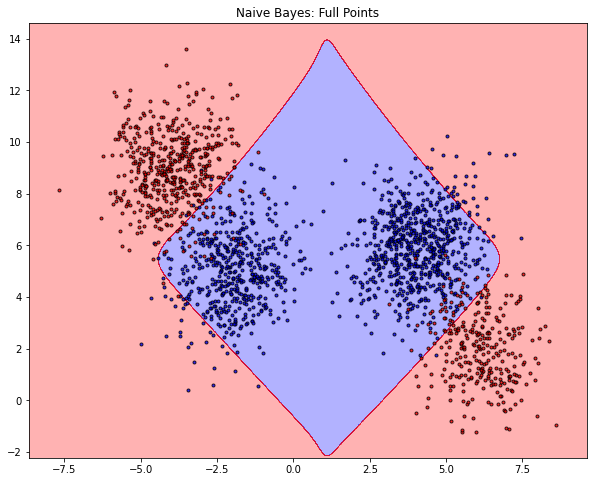

Explanation of the 5th graph: This is the best separation of the full data, with more than 90% accuracy.
We can see that the Algorithm learned the separation of the GMM which is not a straight line, in contrast of the former Logistic Regression separation line.



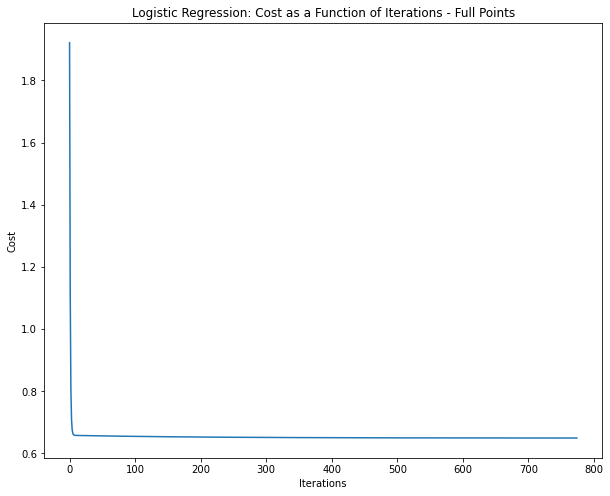

Explanation of the 6th graph: This graph shows us that the Logistic Regression separation cannot be more optimized after performing about 750 iterations, which tells us that the algorithm stopped by the given epsilon.
This is because the full data is not linear separated, and the algorithm reached to its minimum very quickly.


In [12]:
# print('1000 Training Points & 500 Test Points:')
print(f'Logistic Regression: 1000 Points Train Accuracy: {lr_train_acc}%')
print(f'Logistic Regression: 500 Points Test Accuracy:   {lr_test_acc}%\n')
print(f'Naive Bayes: 1000 Points Train Accuracy: {nb_train_acc}%')
print(f'Naive Bayes: 500 Points Test Accuracy:   {nb_test_acc}%\n')

plot_decision_regions(first, train_labels, classifier=lr)
plt.title('Logistic Regression: First 1000 Training Points')
plt.show()
print('Explanation of the 1st graph: We can see that the data can be linear separated with minimal error.')
print('We can see the line that was created by performing the Logistic Regression Algorithm.\n')

plot_decision_regions(first, train_labels, classifier=nb)
plt.title('Naive Bayes: First 1000 Training Points')
plt.show()
print('Explanation of the 2nd graph: This graph represents the Naïve Bayes Algorithm, which assumes the data is independent')
print('Due to those assumptions, we can see that the line is non-linear and performs better separation than the Logistic Regression.\n')


plt.plot(np.arange(len(lr.costs_list)), lr.costs_list)
plt.title("Logistic Regression: Cost as a Function of Iterations - First 1000 Training Points")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
print('Explanation of the 3d graph: In this graph, which represents the cost of Logistic Regression vs Iterations, the cost starts high on the first iteration, and as we perform more iterations the cost reduces.')
print('This is exactly what we wanted to see, because we aim to minimize the cost to get better performance, as seen on class.')
print('Moreover, we van notice that the algorithm performed the maximum number of iterations and didn’t stop by the given epsilon.\n\n')

print('Full Data set:')
print(f'Logistic Regression: Full Points Train Accuracy: {lr_full_train_acc}%')
print(f'Logistic Regression: Full Points Test Accuracy:   {lr_full_test_acc}%\n')
print(f'Naive Bayes: Full Points Train Accuracy: {nb_full_train_acc}%')
print(f'Naive Bayes: Full Points Test Accuracy:   {nb_full_test_acc}%\n')

plot_decision_regions(train_set, train_set[:,-1], classifier=lr_full)
plt.title('Logistic Regression: Full Training & Test Points')
plt.show()
print('Explanation of the 4th graph: In this graph we see worse separation than the previous Logistic Regression separation graph, since we observe all the data points – which have 4 gaussians in different locations.')
print('This is of course non-linear separated.')
print('It aims to separate it as best as it can, with about 80% success rate – the gaussian in the down-right corner is not classified correctly.\n')

plot_decision_regions(train_set, train_set[:,-1], classifier=nb_full)
plt.title('Naive Bayes: Full Points')
plt.show()
print('Explanation of the 5th graph: This is the best separation of the full data, with more than 90% accuracy.')
print('We can see that the Algorithm learned the separation of the GMM which is not a straight line, in contrast of the former Logistic Regression separation line.\n')

plt.plot(np.arange(len(lr_full.costs_list)), lr_full.costs_list)
plt.title("Logistic Regression: Cost as a Function of Iterations - Full Points")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
print('Explanation of the 6th graph: This graph shows us that the Logistic Regression separation cannot be more optimized after performing about 750 iterations, which tells us that the algorithm stopped by the given epsilon.')
print('This is because the full data is not linear separated, and the algorithm reached to its minimum very quickly.')

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [13]:
from scipy.stats import multivariate_normal as mvn

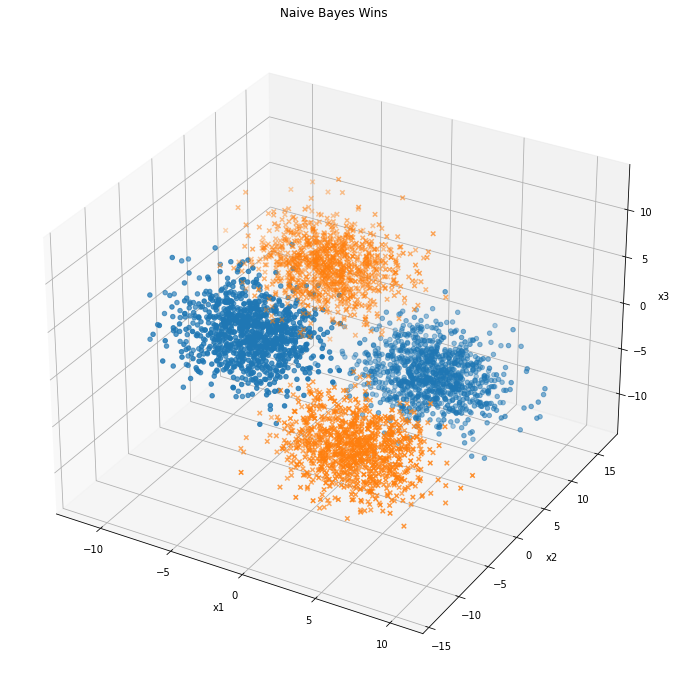

Due to the assumptions that Naive Bayes makes, it is better to generate a data set from a Uniform distribution,
that is not linear dependent.
In this particular case, we can see that there are 4 gaussians, 2 for each class, in a "XOR-like" shape.
As we can see, this data is either not linear separated, which makes the Logistic Regression algorithm to perform
worse than Naive Bayes, as seen in class.


In [14]:
g1 = mvn.rvs([3,8,-6], 5, size=1000)
g2 = mvn.rvs([-4,-5,3], 5, size=1000)
g3 = mvn.rvs([-3,5,5], 5, size=1000)
g4 = mvn.rvs([3,-5,-6], 5, size=1000)

y0 = np.zeros((2000,1))
y1 = np.ones((2000,1))
labels = np.concatenate((np.zeros(2000),np.ones(2000)))

g = np.concatenate((g1,g2))
g = np.concatenate((g,y0),axis=1)

c = np.concatenate((g3,g4))
c = np.concatenate((c,y1),axis=1)

naive_dataset = np.concatenate((g,c))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(naive_dataset[:,0][labels==0], naive_dataset[:,1][labels==0], naive_dataset[:,2][labels==0],marker='o')
ax.scatter(naive_dataset[:,0][labels==1], naive_dataset[:,1][labels==1], naive_dataset[:,2][labels==1],marker='x')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Naive Bayes Wins')
plt.show()

print('Due to the assumptions that Naive Bayes makes, it is better to generate a data set from a Uniform distribution,')
print('that is not linear dependent.')
print('In this particular case, we can see that there are 4 gaussians, 2 for each class, in a "XOR-like" shape.')
print('As we can see, this data is either not linear separated, which makes the Logistic Regression algorithm to perform')
print('worse than Naive Bayes, as seen in class.')

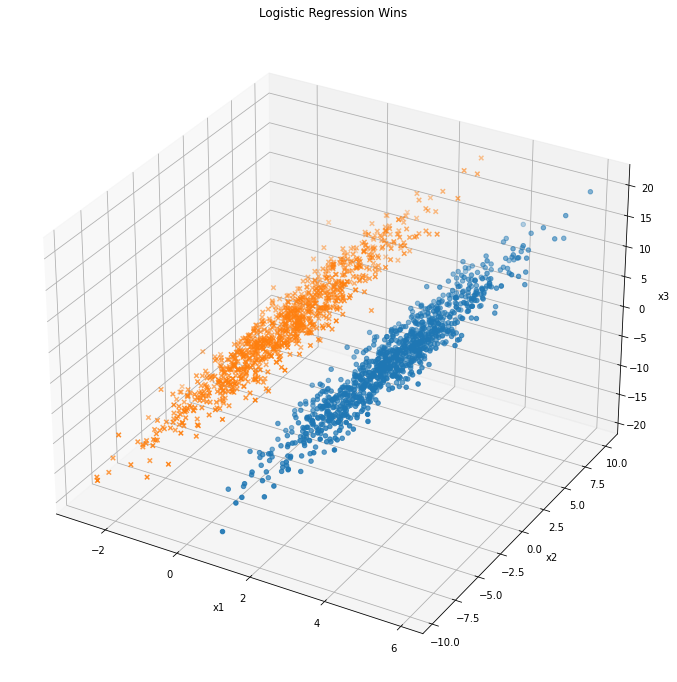

Notice that this data is both linear separated, and linear dependant, thus Logistic Regression works great with
this kind of data, while Naive Bayes, who makes assumption that this data is linear independant - works worse in this case.


In [15]:
x1 = mvn.rvs(0,0.8,2000)
x2 = x1*3 + mvn.rvs(0,1.2,2000)
x3 = x2*2 + mvn.rvs(0,1.4,2000)
labels = np.concatenate((np.zeros(1000),np.ones(1000)))
x1[labels==0]+=3
data = np.column_stack((x1,x2,x3))

logistic_dataset = np.column_stack((data, labels))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(logistic_dataset[:,0][labels==0], logistic_dataset[:,1][labels==0], logistic_dataset[:,2][labels==0],marker='o')
ax.scatter(logistic_dataset[:,0][labels==1], logistic_dataset[:,1][labels==1], logistic_dataset[:,2][labels==1],marker='x')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Logistic Regression Wins')
plt.show()

print('Notice that this data is both linear separated, and linear dependant, thus Logistic Regression works great with')
print('this kind of data, while Naive Bayes, who makes assumption that this data is linear independant - works worse in this case.')